In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Cargo el datasel del GCBA

In [2]:
datos = pd.read_csv("casos_covid19.csv",dtype = {"fallecido":str,"tipo_contagio":str}, parse_dates = [1,2,3,10,12], date_parser = lambda col: pd.to_datetime(col, format = "%d%b%Y:%H:%M:%S.%f"))

Me quedo con los casos positivos de residentes

In [3]:
positivos = datos[datos.clasificacion == "confirmado"]
positivos = positivos[positivos.provincia == "CABA"]

Esta función me da la cantidad de positivos en un día y entre edadmin y edadmax

In [4]:
def casos_dia(dia,edadmin = None, edadmax = None):
	if edadmin is None and edadmax is None:
		casos = positivos[positivos["fecha_toma_muestra"] == dia].numero_de_caso.count()
	else:
		casos = positivos[(positivos["fecha_toma_muestra"] == dia) & ((positivos["edad"] >= edadmin) & (positivos["edad"] < edadmax))].numero_de_caso.count()
	return casos

Esta función me da la cantidad de positivos entre el día inicio (incluido) y el día fin (no incluido) y entre edadmin y edadmax

In [5]:
def casos_entre(inicio,fin,edadmin = None, edadmax = None):
	if edadmin is None and edadmax is None:
		casos = positivos[((positivos["fecha_toma_muestra"] >= inicio) & (positivos["fecha_toma_muestra"] < fin))].numero_de_caso.count()
	else:
		casos = positivos[((positivos["fecha_toma_muestra"] >= inicio) & (positivos["fecha_toma_muestra"] < fin)) & ((positivos["edad"] >= edadmin) & (positivos["edad"] < edadmax))].numero_de_caso.count()
	return casos

Y esta me da el promedio centrado en el día (3 días para atrás y 3 días para delante)

In [6]:
def casos_dia_promedio(dia,edadmin = None, edadmax = None):
	inicio = dia - pd.Timedelta("3 d")
	fin = dia + pd.Timedelta("4 d")
	if edadmin is None and edadmax is None:
		casos = positivos[((positivos["fecha_toma_muestra"] >= inicio) & (positivos["fecha_toma_muestra"] < fin))].numero_de_caso.count()/7
	else:
		casos = positivos[((positivos["fecha_toma_muestra"] >= inicio) & (positivos["fecha_toma_muestra"] < fin)) & ((positivos["edad"] >= edadmin) & (positivos["edad"] < edadmax))].numero_de_caso.count()/7
	return casos

Calculo casos por semana y por franja etaria desde la semana del 15/2, ccuando arrancaron las clases. También el aumento (por cuanto se multiplican) tomando como basa la primera semana

In [7]:
semanas = pd.date_range("20210215","20210411",freq="W-MON")
faños = 20 # franjas de cuantos años
edades = [[a,a+faños] for a in range(0,100,faños)]

#Casos y aumento por franja etaria
casos = []
aumento = []
for edad in edades:
	casos_franja = []
	aumento_franja = []
	for semana in semanas:
		casos_franja.append(casos_entre(semana,semana+pd.Timedelta("1 w"),edad[0],edad[1]))
		aumento_franja.append((casos_franja[-1]/casos_franja[0]))
	casos.append(casos_franja)
	aumento.append(aumento_franja)

#Casos y aumento promedio
casos_totales = []
aumento_totales = []
for semana in semanas:
	casos_totales.append(casos_entre(semana,semana+pd.Timedelta("1 w")))
	aumento_totales.append((casos_totales[-1]/casos_totales[0]))

Gráfico razón de crecimiento por franja etaria

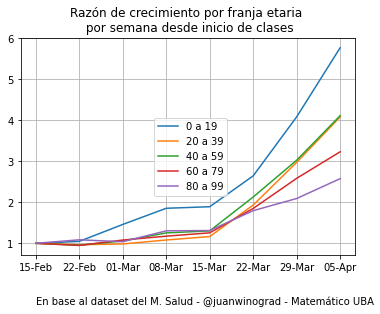

In [22]:
fig, ax = plt.subplots(1)
for i in range(len(edades)):
	color=next(ax._get_lines.prop_cycler)['color']
	ax.plot(semanas,aumento[i],label=str(edades[i][0])+" a "+str(edades[i][1]-1),color = color)
fig.legend(loc = ("center"))
plt.title("Razón de crecimiento por franja etaria \n por semana desde inicio de clases")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.grid()
#fig.autofmt_xdate()
loc, labels = plt.xticks(semanas)
firma = plt.text(semanas[0],-0.5, "En base al dataset del M. Salud - @juanwinograd - Matemático UBA")
plt.savefig("aumento por franja.png")

Comparo primera franja con total

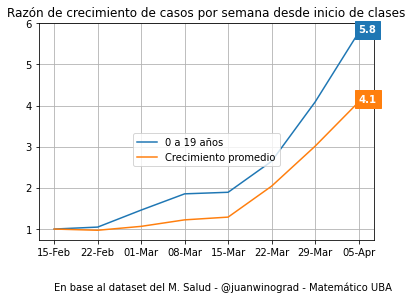

In [23]:
fig, ax = plt.subplots(1)
color=next(ax._get_lines.prop_cycler)['color']
ax.plot(semanas,aumento[0],label=str(edades[0][0])+" a "+str(edades[0][1]-1)+" años", color = color)
plt.text(semanas[-1],aumento[0][-1],round(aumento[0][-1],1),backgroundcolor=color,color="white",fontweight="bold")

color=next(ax._get_lines.prop_cycler)['color']
ax.plot(semanas,aumento_totales,label="Crecimiento promedio",color = color)
plt.text(semanas[-1],aumento_totales[-1],round(aumento_totales[-1],1),backgroundcolor=color, color="white",fontweight="bold")

fig.legend(loc = "center")
plt.title("Razón de crecimiento de casos por semana desde inicio de clases")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.grid()
#fig.autofmt_xdate()
loc, labels = plt.xticks(semanas)
firma = plt.text(semanas[0],-0.5, "En base al dataset del M. Salud - @juanwinograd - Matemático UBA")
plt.savefig("aumento sub20 vs media.png")

Calculo evolución hipotetica de la primera franja siguiendo la dináimca genera

In [10]:
casos_hip = []
for i in range(len(semanas)):
    casos_hip.append(casos[0][0]*aumento_totales[i])

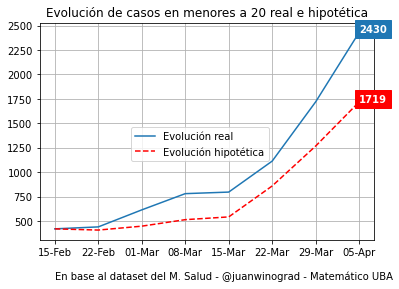

In [25]:
fig, ax = plt.subplots(1)
color=next(ax._get_lines.prop_cycler)['color']
ax.plot(semanas,casos[0],label="Evolución real", color = color)
plt.text(semanas[-1],casos[0][-1],casos[0][-1],backgroundcolor=color,color="white",fontweight="bold")

color=next(ax._get_lines.prop_cycler)['color']
ax.plot(semanas,casos_hip, "r--",label="Evolución hipotética")
plt.text(semanas[-1],casos_hip[-1],round(casos_hip[-1]),backgroundcolor="red", color="white",fontweight="bold")

fig.legend(loc = "center")
plt.title("Evolución de casos en menores a 20 real e hipotética")




ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.grid()
#fig.autofmt_xdate()
loc, labels = plt.xticks(semanas)
firma = plt.text(semanas[0],-100, "En base al dataset del M. Salud - @juanwinograd - Matemático UBA")
plt.savefig("evolución hipotética.png")

In [12]:
print("Diferencia: "+str(round(casos[0][-1]-casos_hip[-1])))

Diferencia: 711


POR NIVEL EDUCATIVO

In [13]:
niveles = {'Inicial':[0,6],'Primaria':[6,13],'Secundaria':[13,19]}
casos_nivel = []
aumento_nivel = []

for niv in niveles:
	casos_franja = []
	aumento_franja = []
	for semana in semanas:
		casos_franja.append(casos_entre(semana,semana+pd.Timedelta("1 w"),niveles[niv][0],niveles[niv][1]))
		aumento_franja.append((casos_franja[-1]/casos_franja[0]))
	casos_nivel.append(casos_franja)
	aumento_nivel.append(aumento_franja)

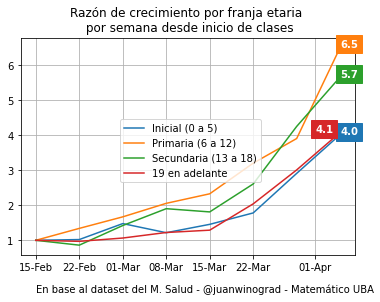

In [26]:
fig, ax = plt.subplots(1)

for i in range(len(niveles)):
	color=next(ax._get_lines.prop_cycler)['color']
	ax.plot(semanas,aumento_nivel[i],label=list(niveles)[i]+ " ("+str(niveles[list(niveles)[i]][0])+" a "+str(niveles[list(niveles)[i]][1]-1)+")",color = color)
	plt.text(semanas[-1],aumento_nivel[i][-1],round(aumento_nivel[i][-1],1),backgroundcolor=color, color="white",fontweight="bold")

color=next(ax._get_lines.prop_cycler)['color']
ax.plot(semanas,aumento_totales,label="19 en adelante",color = color)
plt.text(semanas[-1]-pd.Timedelta("4 d"),aumento_totales[-1],round(aumento_totales[-1],1),backgroundcolor=color, color="white",fontweight="bold")

fig.legend(loc = ("center"))
plt.title("Razón de crecimiento por franja etaria \n por semana desde inicio de clases")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.grid()
firma = plt.text(semanas[0],-0.5, "En base al dataset del M. Salud - @juanwinograd - Matemático UBA")
plt.savefig("aumento por nivel.png")

Casos promedio por día desde el inicio de la pandemia

In [15]:
dias = pd.date_range("20200316","20210411",freq="D")

casos_dia_nivel = []
for niv in niveles:
    casos_franja = []
    for dia in dias:
        casos_franja.append(casos_dia_promedio(dia,niveles[niv][0],niveles[niv][1]))
    casos_dia_nivel.append(casos_franja)

casos_dia_totales = []
for dia in dias:
    casos_dia_totales.append(casos_dia_promedio(dia))

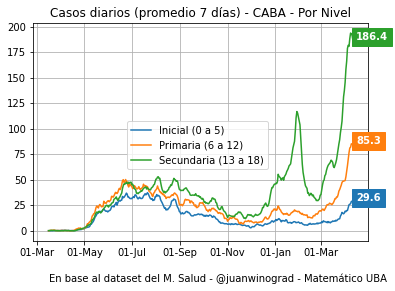

In [27]:
fig, ax = plt.subplots(1)

for i in range(len(niveles)):
	color=next(ax._get_lines.prop_cycler)['color']
	ax.plot(dias,casos_dia_nivel[i],label=list(niveles)[i]+ " ("+str(niveles[list(niveles)[i]][0])+" a "+str(niveles[list(niveles)[i]][1]-1)+")",color = color)
	plt.text(dias[-1]+pd.Timedelta("4 d"),casos_dia_nivel[i][-1],round(casos_dia_nivel[i][-1],1),backgroundcolor=color, color="white",fontweight="bold")

fig.legend(loc = ("center"))
plt.title("Casos diarios (promedio 7 días) - CABA - Por Nivel")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.grid()
firma = plt.text(dias[0],-50, "En base al dataset del M. Salud - @juanwinograd - Matemático UBA")
plt.savefig("casos diarios por nivel.png")

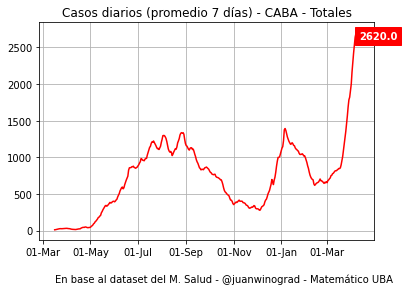

In [28]:
fig, ax = plt.subplots(1)

color="r"
ax.plot(dias,casos_dia_totales,label="Crecimiento promedio",color = color)
plt.text(dias[-1],casos_dia_totales[-1],round(casos_dia_totales[-1],1),backgroundcolor=color, color="white",fontweight="bold")

plt.title("Casos diarios (promedio 7 días) - CABA - Totales")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.grid()
firma = plt.text(dias[0],-700, "En base al dataset del M. Salud - @juanwinograd - Matemático UBA")
plt.savefig("casos diarios.png")